# Sobre a modelagem

As bibliotecas *Numpy* e *MatPlotLib* devem ser importadas para que tenhamos métodos para calcular as equações e Plotar a dinâmica, respectivamente.

O artigo apresenta a modelagem de um sistema CSTR através das seguintes equações, no estado estacionário:

$$
F_o(C_{Ao} - C_A) - VkC_A = 0 
$$ 

$$ 
\rho C_pF_o(T_o-T_j) - \lambda VkC_A - UA(T - T_j) = 0
$$

$$
\rho_j C_jF_j(T_{jo}-T_j)+UA(T - T_j) = 0
$$

Ocorre que $k = \alpha e^{E/RT}$ , o que nos leva a reescrever as duas primeiras equações como:

$$
F_o(C_{Ao} - C_A) - V \alpha e^{E/RT} C_A = 0
$$ 

$$ 
\rho C_pF_o(T_o-T_j) - \lambda V \alpha e^{E/RT} C_A - UA(T - T_j) = 0
$$

Fazemos isso para obter três equações e três variáveis para as quais devemos resolver essas equações, a saber: $T$ , $C_j$ e $T_j$. Sendo assim, temos um sistema de equações não lineares. 

É preciso notar que essas equações podem ter múltiplas soluções. Sendo assim, a resolução direta dessas equações não nos fornecerá todos os estados estacionários — como o próprio artigo argumenta —, mas bastará para os objetivos desta demonstração. Além disso, os estados estacionários dependem da temperatura de entrada do fluido, que vamos tratar como uma constate $T_o = 530°C$

Logo, o que faremos é:

* Encontrar pelo menos uma solução de estado estacionário e;
* Plotar a dinâmica do sistema utilizando método de Euler.

In [2]:
import numpy as np
import pyomo as pyo
import matplotlib as plt
from math import exp

# Resolvendo Sistema com Pyomo

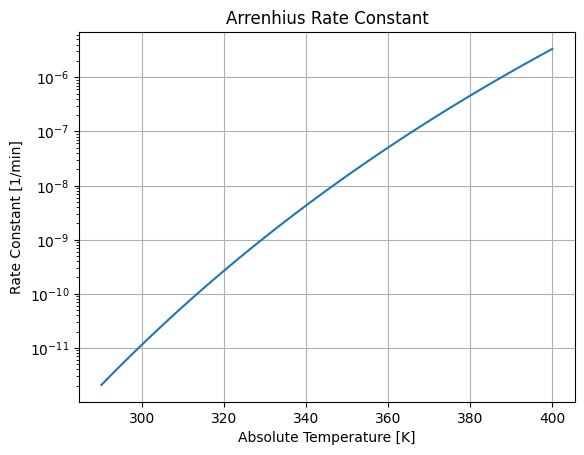

In [116]:
Ea = 30000     # activation energy J/gmol
R = 1.99      # gas constant J/gmol/K
k0 = 7.8e10    # Arrhenius rate constant 1/min

# Arrhenius rate expression
def k(T):
    return k0*np.exp(-Ea/R/T)

T = np.linspace(290, 400)
plt.semilogy(T, k(T))
plt.xlabel('Absolute Temperature [K]')
plt.ylabel('Rate Constant [1/min]')
plt.title('Arrenhius Rate Constant')
plt.grid();

# Plot da dinâmica 

In [7]:
# reaction and physical properities parameters
Ea = 3e4      # activation energy J/gmol
R = 1.99        # gas constant J/gmol/K
k0 = 7.8e10     # Arrhenius rate constant 1/min
dHr = -3e4    # lambda : enthalpy of reaction [BTU/mol]
rho = 50        # density [lbm/ft3]
rhoj = 62.3       # densidade do refrigerante [lbm/ft3]
Cp = 0.75      # heat capacity [BTU/lbm/°R]
UA = 3.75e4      # heat transfer [BTU/hr-1/°R]

# reactor operating parameters
V = 48          # volume [ft3]
Fo = 100.0      # flowrate [ft3/hr]
cAo = 0.5       # inlet feed concentration [mol/ft3]
Cj = 1          # concentração do refrigerante [mol/ft3]
To = 530      # inlet feed temperature [°R]
Tc = 530      # coolant temperature [°R]
Toj =530

# simulation parameters
cAo = 0.5       # initial concentration [mol/L]
To = 530      # initial temperature [K]
t_initial = 0.0 # initial time
t_final = 10.0  # final time

def cstr(cA0=cAo, T0=To):
    """Return a pyomo model with specified initial conditions."""
    
    # create a model instance
    model = pyo.ConcreteModel()
    
    # define independent variable
    model.t = pyo.ContinuousSet(bounds=(t_initial, t_final))
    
    # define dependent variables
    model.cA = pyo.Var(model.t)
    model.T = pyo.Var(model.t)
    
    # define derivatives of the dependent variables
    model.dcA = pyo.DerivativeVar(model.cA)
    model.dT = pyo.DerivativeVar(model.T)

    # set initial conditions
    model.cA[0.0] = cA0
    model.T[0.0] = T0
    
    # define constraints using model equations
    def k(T):
        return k0*exp(-Ea/R/T)
    model.ode1 = pyo.Constraint(model.t, rule=lambda model, t: 
        V*model.dcA[t] == Fo*(cAo - model.cA[t]) - V*k(model.T[t])*model.cA[t])
    model.ode2 = pyo.Constraint(model.t, rule=lambda model, t: 
        V*rho*Cp*model.dT[t] == Fo*rho*Cp*(To - model.T[t]) + (-dHr)*V*k(model.T[t])*model.cA[t] + UA*(Tc - model.T[t]))
    model.ode3 = pyo.Constraint(model.t, rule=lambda model, t: 
        rhoj*Cj*Fj*model.dTj[t] == rhoj*Cj*Fj*(Tjo - T) + UA*(T - model.Tj[t]))

    print(model)
    return model

In [ ]:
def create_cstr_plot_axes():
    fig = plt.figure(figsize=(12,8))
    ax = [plt.subplot(2, 2, k) for k in range(1, 4)]
 
    ax[0].set_xlabel('Time [min]')
    ax[0].set_ylabel('Concentration [gmol/liter]')
    ax[0].set_title('Concentration')
    ax[0].set_ylim(0, 1)
    ax[0].grid(True)
        
    ax[1].set_xlabel('Time [min]')
    ax[1].set_ylabel('Temperature [K]');
    ax[1].set_title('Temperature')
    ax[1].set_ylim(300, 450)
    ax[1].grid(True)
        
    ax[2].set_xlabel("Concentration [gmol/liter]")
    ax[2].set_ylabel("Temperature [K]");
    ax[2].set_title("Phase Plot")
    ax[2].set_xlim(0, 1)
    ax[2].set_ylim(300, 450)
    ax[2].grid(True)
    
    return ax

def cstr_plot(t, y, ax):
    """Plot cstr simulation results. Create new axes if needed."""
    ax[0].plot(t, y[:, 0], label=str(Tc))
    ax[1].plot(t, y[:, 1], label=str(Tc))
    ax[2].plot(y[0, 0], y[0, 1], 'r.', ms=20)
    ax[2].plot(y[:, 0], y[:, 1], lw=2, label=str(Tc))
    for a in ax:
        a.legend()

ax = create_cstr_plot_axes()
cstr_plot(tsim, ysim, ax);